# Melbourne Housing Price Prediction

## Importing libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

## Data preprocessing

### Importing data

In [6]:
data = pd.read_csv('Melbourne_housing_price.csv')

### Handling missing values

In [8]:
# Loop through all columns
for col in data.columns:
    if data[col].isnull().sum() > 0:
        if pd.api.types.is_numeric_dtype(data[col]):
            # Numeric column: decide mean/median based on skewness
            if -0.5 <= data[col].skew() <= 0.5:
                fill_value = data[col].mean()
            else:
                fill_value = data[col].median()
            data.fillna({col: fill_value}, inplace=True)
        else:
            # Categorical column: use mode
            mode = data[col].mode()
            data.fillna({col: mode[0]}, inplace=True)

### Extracting year, month, day of "Date" & dropping "Address"

In [10]:
# Extract year, month, and day
data["Date"] = pd.to_datetime(data["Date"])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
# Drop "Address"
data = data.drop(columns=["Address"])

### Create "Building Density" feature

In [12]:
# how much each building occupies its land
data['BuildingDensity'] = data['BuildingArea'] / data['Landsize']
# replace infinite values with 0
data['BuildingDensity'].replace([float('inf'), float('-inf')], 0, inplace=True)

# save dataframe
data.to_csv("prepared_data.csv", index=False)

### Encode categorical variables

In [14]:
# save 'Suburb' column
suburb_col = data['Suburb']

# Select categorical columns to encode
categorical_cols = ['Suburb', 'Type', 'ParkingArea']
# Separate categorical and numerical columns
categorical_data = data[categorical_cols]
numerical_data = data.drop(columns=categorical_cols)
# Initialise OneHotEncoder (drop baseline variable)
encoder = OneHotEncoder(drop='first', sparse_output=False)
# Encode the categorical data
encoded_data = encoder.fit_transform(categorical_data)
# Get new column names from the encoder
encoded_col_names = encoder.get_feature_names_out(categorical_cols)
# Create dataframe from encoded data and column names
encoded_df = pd.DataFrame(encoded_data, columns=encoded_col_names)
# Combine encoded categorical data with original numerical data
data = pd.concat([numerical_data.reset_index(drop=True), encoded_df], axis=1)
# Rename columns
# Rename encoded columns to cleaner names
data = data.rename(columns={'Type_t': 'Type_Townhouse',
                            'Type_u': 'Type_Unit'})

### Standardise numerical features

In [16]:
numerical_features = ['Bedroom', 'Bathroom', 'Landsize', 'BuildingArea', 'YearBuilt',
                      'Latitude', 'Longtitude', 'BuildingDensity', 'Year', 'Month', 'Day']
scaler = StandardScaler()

data[numerical_features] = scaler.fit_transform(data[numerical_features])

### Visualising housing price distribution

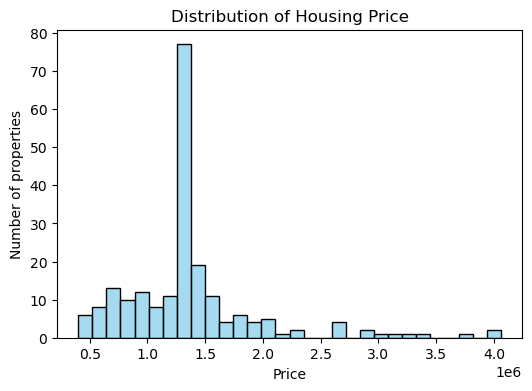

In [18]:
# Plot histogram of house prices
plt.figure(figsize=(6,4))
sns.histplot(data['Price'], bins=30, color='skyblue')
plt.title('Distribution of Housing Price')
plt.xlabel('Price')
plt.ylabel('Number of properties')
plt.show()

### Visualising feature to target correlations

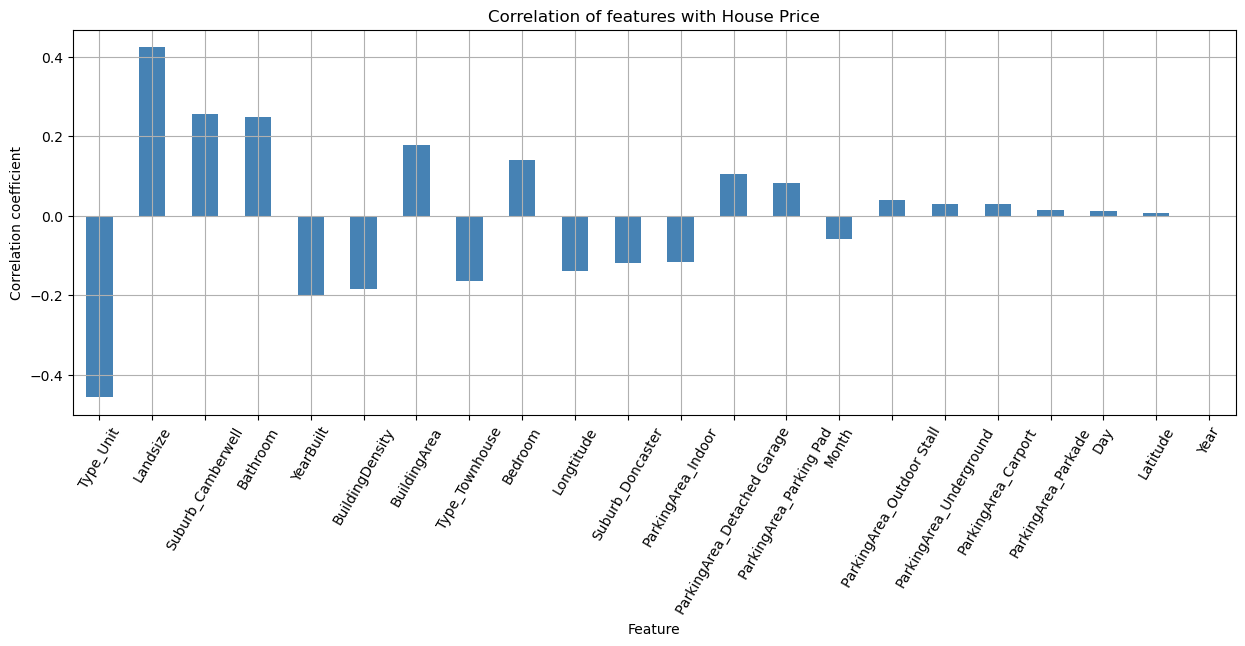

In [20]:
# Compute correlation of all features
correlation_matrix = data.corr(numeric_only=True)
# Extract only the correlations with the target 'Price'
price_correlation = correlation_matrix['Price'].drop('Price')
# Sort correlations
sorted_corr = price_correlation.sort_values(key=abs, ascending=False)
# Plot
plt.figure(figsize=(15,5))
sorted_corr.plot(kind='bar', color='steelblue')
plt.title('Correlation of features with House Price')
plt.ylabel('Correlation coefficient')
plt.xlabel('Feature')
plt.xticks(rotation=60)
plt.grid(True)
plt.show()

### Visualising outliers

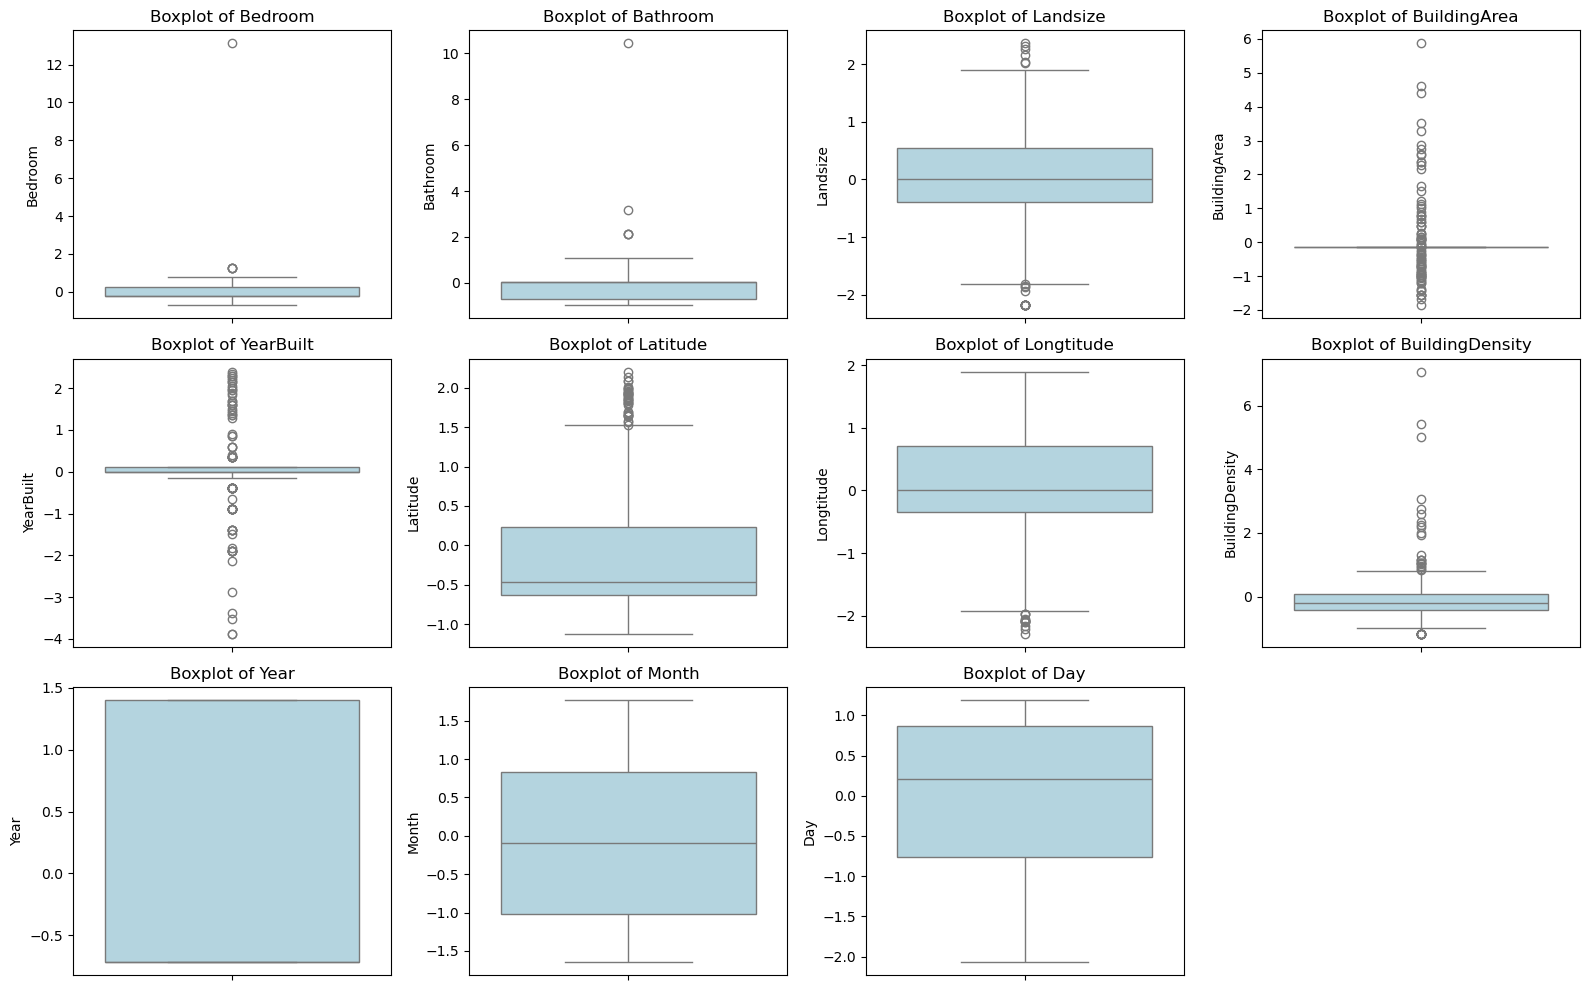

In [22]:
# Plot boxplots in a grid
plt.figure(figsize=(16, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 4, i+1)
    sns.boxplot(y=data[col], color='lightblue')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.show()

### Identifying price trends over time across suburbs

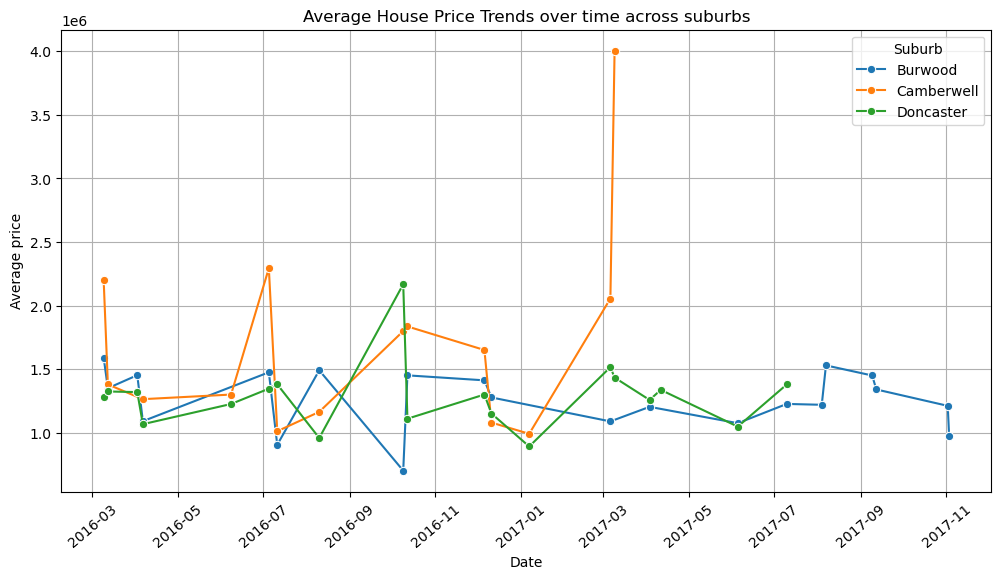

In [24]:
# saved Suburb column
data['Suburb'] = suburb_col

# Group by Suburb and Date, and take average price
price_trend = data.groupby(['Suburb', 'Date'])['Price'].mean().reset_index()

# Plot price trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=price_trend, x='Date', y='Price', hue='Suburb', marker='o')
plt.title('Average House Price Trends over time across suburbs')
plt.xlabel('Date')
plt.ylabel('Average price')
plt.legend(title='Suburb')
plt.xticks(rotation=40)
plt.grid(True)
plt.show()

# Drop these to proceed to training the models
data = data.drop(columns=['Date', 'Suburb'])

## Model development

### Evaluating Linear Regression, Support Vector Regression, and Decision Tree Regression

In [27]:
# Prepare features and target
y = data['Price']
X = data.drop(columns=['Price'])

# Set up k-fold cross-validation
five_folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Use 5 Models
models = {'Linear Regression': LinearRegression(),
          'SVR': SVR(kernel='rbf'),
          'Decision Tree': DecisionTreeRegressor(random_state=42),
          'Random Forests': RandomForestRegressor(random_state=42),
          'Gradient Boosting': GradientBoostingRegressor(random_state=42)}

# Evaluate them
results = []
for name, model in models.items():
    # Cross-validated predictions
    y_prediction = cross_val_predict(model, X, y, cv=five_folds)
    # evaluate with metrics
    mae = mean_absolute_error(y, y_prediction)
    rmse = np.sqrt(mean_squared_error(y, y_prediction))
    r2 = r2_score(y, y_prediction)
    # add all calculated metrics of a model to the `results` list
    results.append({'Model': name,
                    'MAE': mae,
                    'RMSE': rmse,
                    'R-squared': r2})

# Display results
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='R-squared', ascending=False))

               Model            MAE           RMSE  R-squared
4  Gradient Boosting  325263.016992  476999.491715   0.356861
3     Random Forests  328368.714286  491867.963019   0.316141
0  Linear Regression  370163.646056  547303.317499   0.153308
2      Decision Tree  366555.714286  580954.065105   0.045990
1                SVR  350279.253169  597474.399493  -0.009039


### Saving the best model

In [29]:
# Choose Gradient Boosting since it's the best model
best_model = GradientBoostingRegressor(random_state=42)

# Train it on the full dataset
best_model.fit(X, y)

# Save model for use in Streamlit app
joblib.dump(best_model, "house_price_model.pkl")

['house_price_model.pkl']

### Determining feature importance with decision tree regression

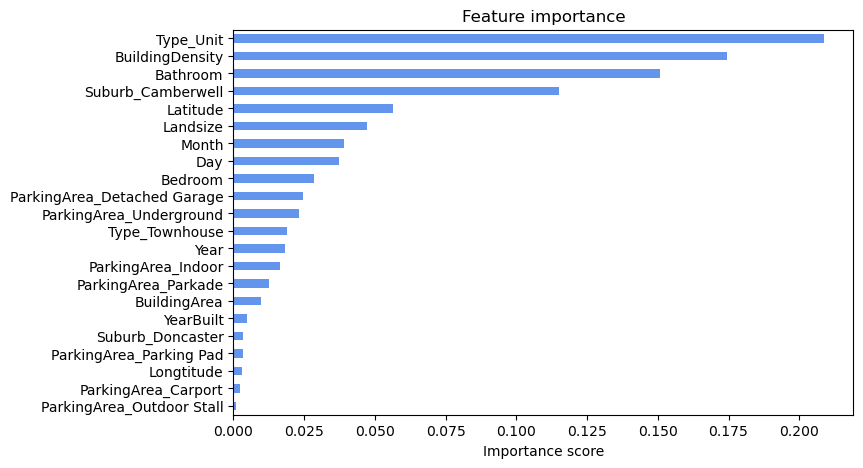

In [31]:
# Fit model
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X, y)

# Get feature importances
importances = pd.Series(tree_model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=True)

# Plot
plt.figure(figsize=(8, 5))
importances.plot(kind='barh', color='cornflowerblue')
plt.title('Feature importance')
plt.xlabel('Importance score')
plt.show()